# Lab Session: Write-along introduction to Deep Learning

Lab objectives:
- develop intuition for Deep Learning (DL) 
- introduction to PyTorch
- core concepts of training Deep Neural Networks in practice.

Lab format
- We will be doing this lab session **all together**: I will tell you what to write in the code as we move forward. 
- **The core idea of the lab is to use the whole class to search for hyperparameters** as a mini data center. I will tell each table which parameters to input, which will give us a broad view of what works best for this problem. Make sure you follow along!
- This lab is *not graded*. We still require your presence so we can run all the experiments together in parallel. You won't need anything but the notebook and an environment to run it. **You don't need ChatGPT open for anything!**

## 0. Loading the Data: the classic MNIST dataset
The dataset we will use is MNIST, consisting of 60k hand-written digits; the goal is to tell which number is on the image, or in other words to "read" hand-written digits. There are 10k testing samples in addition to the 60k training samples.

We will be using [this tuto](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118) as a guide for most of the prep work.

In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision import datasets
from torchvision.transforms import ToTensor

The dataset is split into 50k elements in `train_data`, which we will use to train the network with backprop, and 10k elements in `test_data`, which we will use as never-seen digits to test the network.

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,         
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

Let's see how these look:

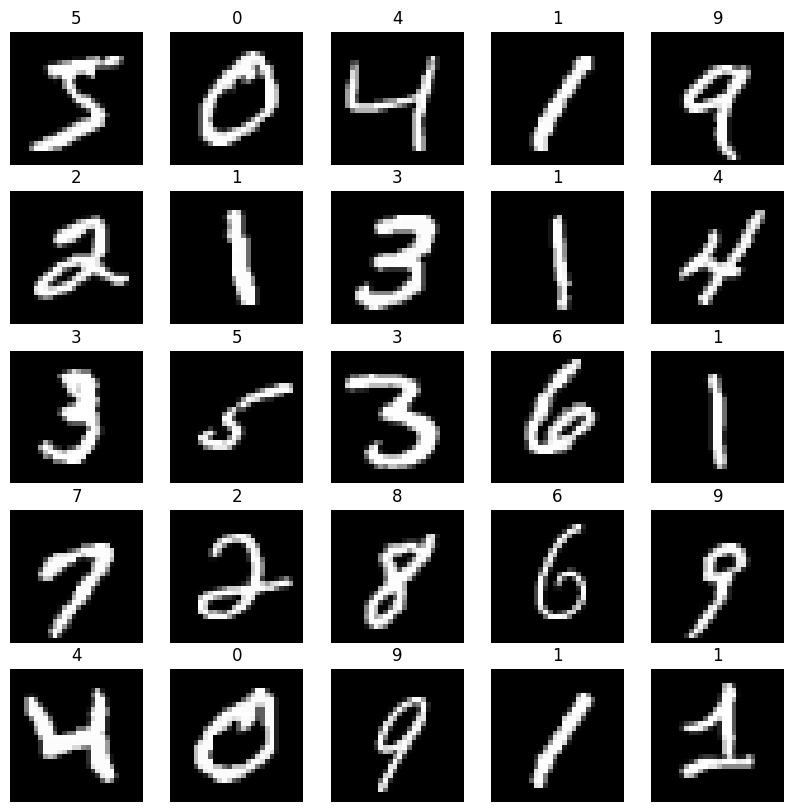

In [3]:
fig, axs = plt.subplots(5,5, figsize=(10,10))
for i,ax in enumerate (axs.flatten()):
    ax.imshow(train_data.data[i], cmap='gray') # visualize the image
    ax.set_title(train_data.targets[i].item()) # what it was supposed to be
    ax.set_axis_off()
plt.show()


What is the shape of these images?

In [4]:
print("Image shape: {}".format(train_data.data[0].shape))

Image shape: torch.Size([28, 28])


We will want to sample from the test or train set during training and testing. In order to do this automatically, we use DataLoaders:

In [5]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=1),
    'test'  : torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True, num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7a6902d6eb70>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7a6903208cb0>}

We can loop over the loaders in batches using a for loop:

In [6]:
for image, label in loaders['test']:
    print(image.shape, label.shape)
    break

torch.Size([32, 1, 28, 28]) torch.Size([32])


Torch treats images with the number of *channels*, mainly 3 channels for RGB. In our case, we have grayscale images, n_channels=1.

## 1. The Fully Connected Network (aka MLP, Multi Layer Perceptron)

A *Fully Connected* or *Multilayer Perceptron* (MLP) is the most elementary class of feed forward artificial neural network (ANN).

<!-- ![image.png](attachment:image.png)
 -->
<img src=https://scikit-learn.org/stable/_images/multilayerperceptron_network.png alt="drawing" width="400"/>

[Image source](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)

The core operation of the Fully Connected Network is to apply a linear mapping (like a linear regression) with parameter matrix $W$ and bias vector $b$, followed by an activation function $\sigma$:

$$ l_i (x) = \sigma (Wx + b) $$

This is a single "layer" $l_i$; the "multi-layer" network chains these operations together: 

$$ f_\theta(x) = l_d (l_{d-1}( \cdots l_2( l_1 (x))\cdots))$$

 The above image shows a one-hidden-layer fully connected network with $n$ inputs and scalar output (1D vector); mathematically, this network with weights called $\theta$ is a function $f_\theta: \mathbb{R}^n \rightarrow \mathbb{R}$.


Most of what we will do from now on can be visualized beforehand on a toy problem using the [Tensorflow Playground](https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=2&seed=0.35230&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false).
On this playground, you can change the inputs, depth and width of the network, learning rate, task and noise, activation function, regularizer, batch size. We very strongly recommend you give it some time to play around, as it is excellent to build an intuition and understand the impact of all the choices the NN designer makes.

### Network architecture
Three main choices can be made about the architecture of a fully connected network:
* *depth*: number of hidden layers
* *width*: number of neurons in each layer
* *non-linearity*: activation functions

Using only one hidden layer, but with sufficient width, ensures that the network is a **Universal Approximator** (can approximate any function $g: \mathbb{R}^n \rightarrow \mathbb{R}$). However, the success of Deep Learning comes from understanding that deeper (more layers) is generally better than wider (more neurons per layer).

In [9]:
# hyperparameters for demonstration purpose only, 
# DO NOT CHANGE HERE FOR A RUN RESULT.
# refer to the lower hyperparameter box for your runs.
HIDDEN_WIDTH = 64
ACTIVATION = F.relu

In [84]:
class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self).__init__()
        self.in_dim = 28*28
        self.out_dim = 10

        self.in_to_hidden1 = nn.Linear(self.in_dim, HIDDEN_WIDTH)
        self.hidden1_to_hidden2 = nn.Linear(HIDDEN_WIDTH, HIDDEN_WIDTH)
        self.hidden2_to_hidden3 = nn.Linear(HIDDEN_WIDTH, HIDDEN_WIDTH)
        self.hidden_to_out = nn.Linear(HIDDEN_WIDTH, self.out_dim)
        
        self.activation = ACTIVATION

    def forward(self, X):
        X = X.squeeze(1) # remove the "channel" dimension (1)
        X = X.flatten(-2,-1) # convert the picture to a single vector

        X = self.activation(self.in_to_hidden1(X))
        X = self.activation(self.hidden1_to_hidden2(X))
        X = self.activation(self.hidden2_to_hidden3(X))
        X = self.hidden_to_out(X)

        # only for non-cross-entropy
        X = F.softmax(X, dim=-1)
        
        return X

Let's try passing the very first element of the dataset in the network:

In [85]:
s0 = train_data.data[0]/255.
net = Net()
prediction_s0 = net(s0)
prediction_s0

tensor([0.0941, 0.1003, 0.0998, 0.1063, 0.0921, 0.1045, 0.1097, 0.1059, 0.0968,
        0.0905], grad_fn=<SoftmaxBackward0>)

For now, these don't correspond to probabilities at all. Depending on the loss function we want to use, we will have to adapt how to interpret the output.

Let's see how to train this!

## 2. Core Training Loop

In order to make experiments scientifically relevant, we need to be able to reset the network and optimizer before each experiment. A useful little function:

In [86]:
# for convenience
def reset(net_class, criterion_class, optim_class, lr):
    net = net_class()
    criterion = criterion_class() # cross entropy loss
    optimizer = optim_class(net.parameters(), lr=lr)
    return net, criterion, optimizer

Now the main training loop:

In [87]:
#from torch.autograd import Variable 
total_step = len(loaders['train'])

def train(num_epochs, loaders, net, optimizer, criterion):
    # Visualization stuff
    logs = {'train_losses':[], 'test_losses':[], 'accuracies':[], 'steps':[], 'test_steps':[]}
    step = 0
    
    # Learning stuff. Set the net to training mode:
    net.train()
    # Learning loop:
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']): # extracts batches of data using loaders
            # Compute loss
            output = net.forward(images)
            labels = F.one_hot(labels, num_classes=10)*1.
            loss = criterion(output, labels) # nn.CrossEntropyLoss(output, labels)
            # Compute gradient (backprop) and apply SGD
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            step += 1

            # logging of training stuff
            logs['train_losses'].append(loss.item())
            logs['steps'].append(step) 
            
            # Testing and logging
            if ((i+1) % 200 == 0) or step==1 : # perform test step
                test_update_logs(logs, net, criterion, i, step, epoch, num_epochs)

    return logs 

In [88]:
def test_update_logs(logs, net, criterion, i, step, epoch, num_epochs):
    test_loss, acc = test(net, criterion)
    print ('Epoch [{}/{}], Step [{}/{}], Test Loss: {:.4f}, Test Accuracy: {:.4f}' 
            .format(epoch + 1, num_epochs, i + 1, total_step, test_loss, acc))
    logs['test_losses'].append(test_loss)
    logs['accuracies'].append(acc)
    logs['test_steps'].append(step)
    if ((i+1)%600)==0:
        plot(logs)

In [89]:
def test(net, criterion):
    # Test the model
    net.eval()    
    with torch.no_grad():
        total_loss = []
        total_acc = []
        for images, labels in loaders['test']:
            test_output = net(images)
            labels_onehot = F.one_hot(labels, num_classes=10)*1.
            test_loss = criterion(test_output, labels_onehot)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))

            total_loss.append(test_loss)
            total_acc.append(accuracy)
    total_loss = np.mean(total_loss)
    total_acc = np.mean(total_acc)
    return total_loss, total_acc

In [90]:
def plot(logs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(logs['steps'], logs['train_losses'], label="train loss")
    ax1.plot(logs['test_steps'], logs['test_losses'], label="test loss")
    ax1.set_yscale('log')
    ax1.set_title("Losses (log scale)")
    ax1.legend()
    ax2.plot(logs['test_steps'], logs['accuracies'])
    ax2.set_title("Accuracy")
    ax2.set_ylim(0,1)
    plt.show()

In [101]:
# Hyperparameter box - change things here to launch a new run!
HIDDEN_WIDTH = 32
ACTIVATION = F.relu
LEARNING_RATE = 0.001
OPTIMIZER = torch.optim.Adam
CRITERION = nn.MSELoss

Epoch [1/1], Step [1/1875], Test Loss: 0.0901, Test Accuracy: 0.1179
Epoch [1/1], Step [200/1875], Test Loss: 0.0262, Test Accuracy: 0.8315
Epoch [1/1], Step [400/1875], Test Loss: 0.0182, Test Accuracy: 0.8859
Epoch [1/1], Step [600/1875], Test Loss: 0.0148, Test Accuracy: 0.9035


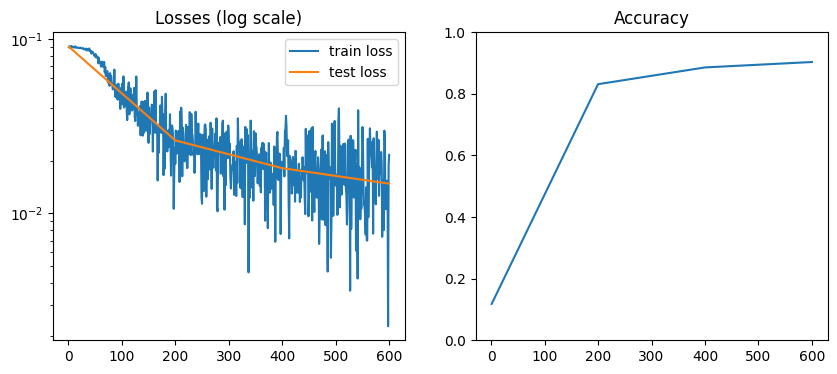

Epoch [1/1], Step [800/1875], Test Loss: 0.0141, Test Accuracy: 0.9067
Epoch [1/1], Step [1000/1875], Test Loss: 0.0136, Test Accuracy: 0.9101
Epoch [1/1], Step [1200/1875], Test Loss: 0.0129, Test Accuracy: 0.9161


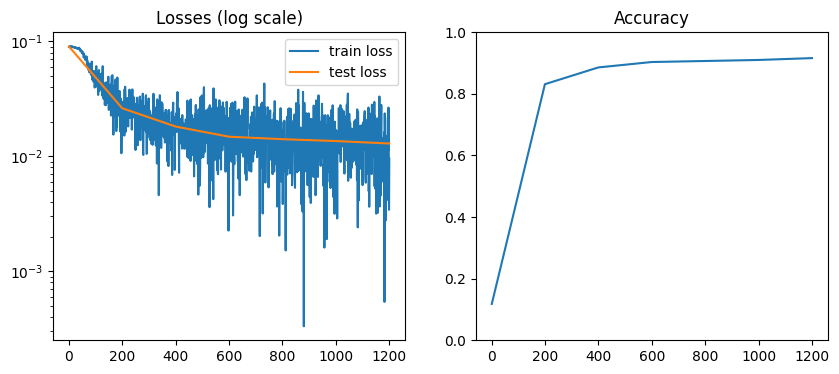

Epoch [1/1], Step [1400/1875], Test Loss: 0.0115, Test Accuracy: 0.9238
Epoch [1/1], Step [1600/1875], Test Loss: 0.0116, Test Accuracy: 0.9247
Epoch [1/1], Step [1800/1875], Test Loss: 0.0105, Test Accuracy: 0.9320


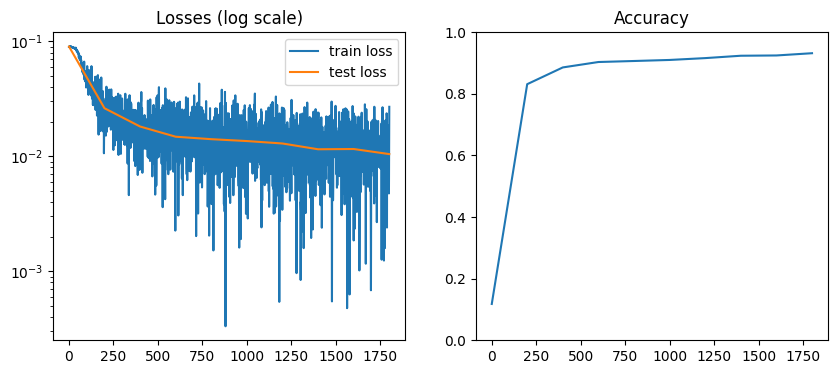

In [102]:
net, criterion, optimizer = reset(Net, CRITERION, OPTIMIZER, lr=LEARNING_RATE)
logs_base = train(1, loaders, net, optimizer, criterion)

In [25]:
print(f"Run Average Accuracy {np.mean(logs_base['accuracies']):.4f}")

Run Average Accuracy 0.7606


## 3. Convolutional Neural Network
Abbraviated CNNs, Convolutional Neural Nets are Artifical Neural Networks with image-specific Convolution layers that are designed to handle visual inputs. In a way, they are less general, 

In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class CNNet(nn.Module):
    def __init__(self):
        super(CNNet, self).__init__()
        self.out_dim = 10
        self.conv1 = nn.Conv2d(1, 16, 5, 3)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Linear(1152, self.out_dim)

    def forward(self, x):
        x = ACTIVATION(self.conv1(x))
        x = ACTIVATION(self.conv2(x))
        x = torch.flatten(x, 1) # flatten
        x = self.fc1(x) # fully connected
        return x

In [ ]:
# Hyperparameter box - change things here to launch a new run!
ACTIVATION = TODO
LEARNING_RATE = TODO
OPTIMIZER = TODO
CRITERION = TODO

In [ ]:
net, criterion, optimizer = reset(CNNet, CRITERION, OPTIMIZER, lr=LEARNING_RATE)
results_cnn = train(1, loaders, net, optimizer, criterion)

## Course reminders for the different hyperparameters and architectural choices

### 1. Architecture
The architecture of the network is the backbone of our function - what type of computations it does. 

Three main choices can be made about the architecture of a fully connected network:

- **Depth**: the number of hidden layers; from an intuitive perspective, the number of layers of "abtraction" that the network learns. Deeper networks might lead to gradient issues without careful management of the architecture and learning algorithm. Increasing the depth linearly increases parameter count, and therefore inference and backprop times.

- **Width**: number of neurons in each layer; from the same intuitive perspective, how many components/dimension in each abstraction. Increasing the width quadratically increases parameter count, and therefore inference and backprop times.

- **Activation function** / **Non-linearity**: How the network will "split" the space at each layer. This is critical to enable universal approximation, but not all activations are equal in practice. The sigmoid, while important from a historic perspective, has issues with its gradient flow, and is now completely obsolete.


### 2. Gradient Descent

Gradient descent follows the opposite direction of the gradient of the loss, 
$$ \theta_i \leftarrow \theta_i + \eta \frac{\partial \mathcal{L}}{\partial \theta_i}. $$

There are a bunch of elements that we can play around with in this formula.

- **Learning Rate**: The learning rate $\eta$ of the gradient descent is a very common and critical hyperparameter in a lot of ML applications, including Deep Learning. <br> <br>
Generally, the learning rate needs to go down when the network gets bigger (finer steps to take), and up when we use bigger batches (more confident gradients). It's quite hard to get a good feel for it, trial and error is necessary. Nowadays, default hyperparameters often work decently well.

- **Loss**:  The loss $\mathcal{L}$ expresses our objective, what we want the network to accomplish (minimize). It is generally some version of "get as close to the ideal function $g(x)=y$", when we only have access to some examples of $y$ (data points). <br>
The most intuitive loss to optimize is simply the Mean Squared Error, $$\mathcal{L}_{\text{MSE}}=\sum_i(f_\theta(x)_i - y_i)^2,$$ trying to minimize the squared distance between your prediction and the ground truth. Other similar losses exist, we will try MAE $\mathcal{L}_{\text{MAE}}=\sum_i \left|f_\theta(x)_i - y_i\right|$ and Huber (combining MSE when higher than 1 and MAE when smaller). <br> <br>
But mainly, we will try CrossEntropy, the main loss for doing classification: $$\mathcal{L}_{\text{CE}}=-\sum_i y_i \log f_\theta(x)_i.$$ For one-hot labels (like our MNIST case here: the digit cannot be 80% a `5` and 20% a `3`, there has to be a single answer), this reduces to $\mathcal{L}_{\text{CE}}=- \log f_\theta(x)_c $ for $c$ the class we should have predicted. In other words: make that class as likely (prediction as high) as possible!

- **Optimizer**
Computing $\partial \mathcal{L} / \partial \theta_i$ over the entire dataset is expensive or sometimes impossible (think ChatGPT with teras of internet text data). Instead we compute it over mini-batches of data, $\partial \mathcal{L}_{mb} / \partial \theta_i$. This means the loss and gradient are now approximations, with noise due to the random sampling of the data: using this to update $\theta_i$ is generally called *Stochastic Gradient Descent*. 
<br> <br>
We can come up with smarter ways of using our approximate gradient, such as using momentum or adaptive learning rates per-parameter $\theta_i$. We then obtain different *optimizers*, different methods to change $\theta_i$ from a given approximate gradient. SGD is the basis, other algorithms came up later, with Adam taking the throne as most popular.

- **Batch size**
The reason the optimizer is called Stochastic Gradient Descent, as opposed to Gradient Descent, is because we only use subsets (batches) of the training data instead of the whole thing at once, acting like a sample in a stochastic computation. This was found to lead to great gains in wall-clock performance, since we don't have to loop over the whole dataset, which might be millions of entries big. In particular, this has lead to huge gains in efficiency thanks to GPUs, massively excelling in parallelized computing but with limited RAM that cannot hold the whole dataset at once.

### 3. Regularization
- **Weight decay**:  A very common cause for overfitting is that the network weights explode - if you try to fit 10 2D points with a 10 degree polynomial, you will often find very high weight values that lead to severe overfitting, rather than truly trying to find the trend.
In order to prevent weight explosion, *L2 Regularization* add a soft constraint to the loss under the form of a $\lambda||w||_2$ term (L1 Reg uses norm 1). This way, the optimizer tries to solve the task using weights as small as possible. Conveniently in PyTorch, [as you can see in the doc](https://docs.pytorch.org/docs/stable/optim.html#per-parameter-options), the Regularization ("weight decay") is an optional argument to the optimizer!
<br> <br>
`optimizer = torch.optim.SGD(net.parameters(), lr=0.01, weight_decay=0.01)`.
<br>
If you want to use it with Adam though, use `AdamW` as an optimizer instead.


- **Dropout** The neurons of a neural network are extremely heavily dependent on the values of the previous neurons - each of the inputs can have a drastic impact on the output. This is often a major culprit for overfitting, where the neurons cannot generalize properly because the new testing distribution looks very different from the training distribution.
<br> <br>
In order to prevent these heavy dependencies, Dropout was introduced. In training, each neuron has some probability to be turned off altogether! This means that the downstream neurons need to be flexible enough to adapt to all kinds of changes in input; no rely too heavily on a single input, but rather find valuable information in all of it.
Dropout can conveniently be seen as an [additional layer](https://pytorch.org/docs/stable/nn.html#dropout-layers), that you can add after any layer (except the output), with a constant giving the probability to turn the neuron off.
